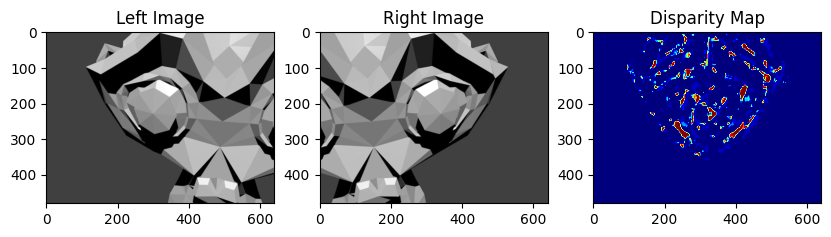

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the left and right images from the provided paths
img_left = cv2.imread('left_image.jpg', cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread('right_image.jpg', cv2.IMREAD_GRAYSCALE)

# Set up the stereo block matcher
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)

# Compute the disparity map
disparity = stereo.compute(img_left, img_right)

# Normalize the disparity map for display
disparity_normalized = cv2.normalize(disparity, disparity, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
disparity_normalized = np.uint8(disparity_normalized)

# Display the images and disparity map
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_left, cmap='gray')
plt.title('Left Image')
plt.subplot(1, 3, 2)
plt.imshow(img_right, cmap='gray')
plt.title('Right Image')
plt.subplot(1, 3, 3)
plt.imshow(disparity_normalized, cmap='jet')
plt.title('Disparity Map')
plt.show()


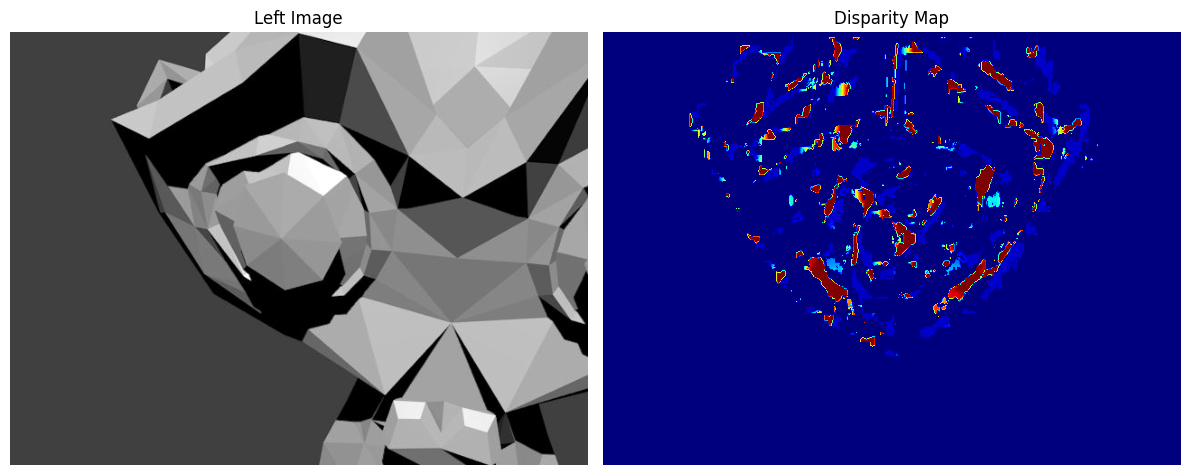

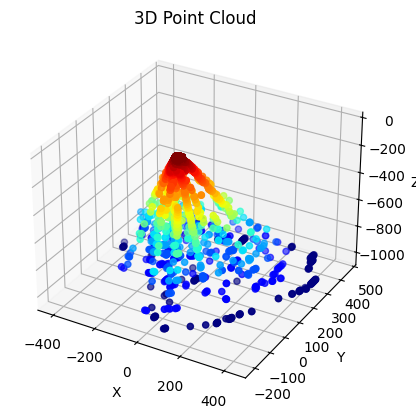

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def stereo_3d_reconstruction(left_image, right_image):
    # Load the stereo images
    left_img = cv2.imread(left_image, cv2.IMREAD_GRAYSCALE)
    right_img = cv2.imread(right_image, cv2.IMREAD_GRAYSCALE)

    # Create a stereo matcher object
    stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)

    # Compute the disparity map
    disparity = stereo.compute(left_img, right_img)

    # Normalize the disparity for better visualization
    disparity_normalized = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # Create a 3D point cloud
    h, w = left_img.shape
    f = 0.8 * w  # Rough estimate of the focal length
    Q = np.float32([[1, 0, 0, -w/2],
                    [0, -1, 0, h/2],
                    [0, 0, 0, -f],
                    [0, 0, 1/16, 0]])

    points_3d = cv2.reprojectImageTo3D(disparity, Q)

    # Filter out points with low disparity (background)
    mask = disparity > disparity.min()
    points_3d = points_3d[mask]

    # Visualize results
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.imshow(left_img, cmap='gray')
    plt.title('Left Image')
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(disparity_normalized, cmap='jet')
    plt.title('Disparity Map')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Visualize 3D point cloud
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c=points_3d[:, 2], cmap='jet')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('3D Point Cloud')
    plt.show()

# Example usage
stereo_3d_reconstruction('left_image.jpg', 'right_image.jpg')

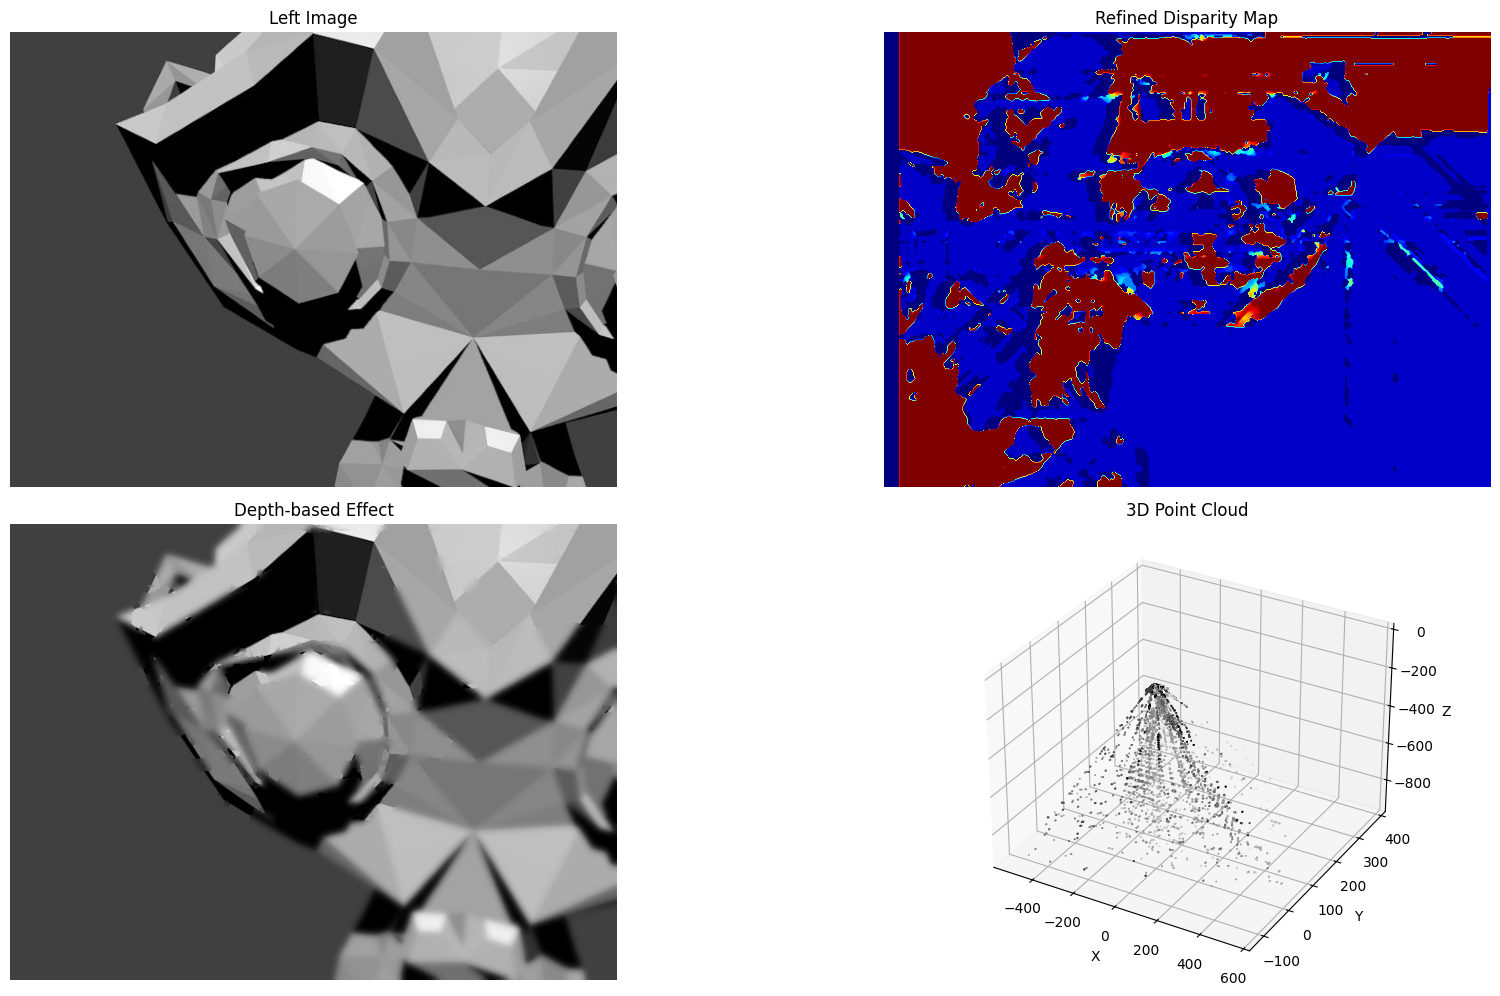

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def refined_stereo_reconstruction(left_image, right_image):
    # Load the stereo images
    left_img = cv2.imread(left_image)
    right_img = cv2.imread(right_image)
    
    # Convert to grayscale
    left_gray = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
    right_gray = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)

    # Create a stereo matcher object (using Semi-Global Block Matching for better results)
    stereo = cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=16,
        blockSize=5,
        P1=8 * 3 * 5**2,
        P2=32 * 3 * 5**2,
        disp12MaxDiff=1,
        uniquenessRatio=10,
        speckleWindowSize=100,
        speckleRange=32
    )

    # Compute the disparity map
    disparity = stereo.compute(left_gray, right_gray)

    # Normalize the disparity for better visualization
    disparity_normalized = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # Create a 3D point cloud (same as before)
    h, w = left_gray.shape
    f = 0.8 * w  # Rough estimate of the focal length
    Q = np.float32([[1, 0, 0, -w/2],
                    [0, -1, 0, h/2],
                    [0, 0, 0, -f],
                    [0, 0, 1/16, 0]])

    points_3d = cv2.reprojectImageTo3D(disparity, Q)

    # Create a depth-based image effect
    def apply_depth_effect(image, disparity):
        # Normalize disparity to 0-1 range
        disp_norm = cv2.normalize(disparity, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        
        # Create a blurred version of the image
        blurred = cv2.GaussianBlur(image, (21, 21), 0)
        
        # Blend original and blurred images based on disparity
        result = image.copy()
        for i in range(3):  # For each color channel
            result[:,:,i] = image[:,:,i] * disp_norm + blurred[:,:,i] * (1 - disp_norm)
        
        return result.astype(np.uint8)

    depth_effect_image = apply_depth_effect(left_img, disparity_normalized)

    # Visualize results
    plt.figure(figsize=(20, 10))
    plt.subplot(221)
    plt.imshow(cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB))
    plt.title('Left Image')
    plt.axis('off')

    plt.subplot(222)
    plt.imshow(disparity_normalized, cmap='jet')
    plt.title('Refined Disparity Map')
    plt.axis('off')

    plt.subplot(223)
    plt.imshow(cv2.cvtColor(depth_effect_image, cv2.COLOR_BGR2RGB))
    plt.title('Depth-based Effect')
    plt.axis('off')

    # Visualize 3D point cloud
    ax = plt.subplot(224, projection='3d')
    mask = disparity > disparity.min()
    ax.scatter(points_3d[mask,0], points_3d[mask,1], points_3d[mask,2], c=left_img[mask].reshape(-1,3)/255.0, s=0.1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('3D Point Cloud')

    plt.tight_layout()
    plt.show()

# Example usage
refined_stereo_reconstruction('left_image.jpg', 'right_image.jpg')

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from torchvision.transforms import Compose
from torchvision.models import resnet50
from torchvision.transforms import transforms

# Define the depth estimation model
class DepthEstimationModel(torch.nn.Module):
    def __init__(self):
        super(DepthEstimationModel, self).__init__()
        self.base_model = resnet50(pretrained=True)
        self.base_model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_features = self.base_model.fc.in_features
        self.base_model.fc = torch.nn.Sequential(
            torch.nn.Linear(num_features, 1),
            torch.nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.base_model(x)

# Load and preprocess the image
def load_image(left_image):
    img = cv2.imread(left_image.jpg)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# Estimate depth
def estimate_depth(model, image):
    transform = Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    input_tensor = transform(image).unsqueeze(0)
    with torch.no_grad():
        depth = model(input_tensor)
    
    depth = depth.squeeze().numpy()
    depth = cv2.resize(depth, (image.shape[1], image.shape[0]))
    return depth

# Create 3D visualization
def create_3d_visualization(image, depth):
    h, w = depth.shape
    x, y = np.meshgrid(np.arange(w), np.arange(h))
    
    fig = plt.figure(figsize=(12, 5))
    
    # Original image
    ax1 = fig.add_subplot(121)
    ax1.imshow(image)
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    # 3D visualization
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(x, y, depth, cmap='viridis', rstride=1, cstride=1)
    ax2.set_title('3D Visualization')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Depth')
    
    plt.tight_layout()
    plt.show()

# Main function
def single_image_3d_visualization(left_image):
    # Load image
    image = load_image(left_image.jpg)
    
    # Load model
    model = DepthEstimationModel()
    model.eval()
    
    # Estimate depth
    depth = estimate_depth(model, image)
    
    # Create 3D visualization
    create_3d_visualization(image, depth)

# Example usage
single_image_3d_visualization('left_image.jpg')

OSError: [WinError 126] The specified module could not be found. Error loading "c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\lib\fbgemm.dll" or one of its dependencies.